# Modelling discontinuous trapped concentration profiles

It is possible to set the finite element type of trapped concentration in FESTIM.
But why even bother?

It basically helps have a better approximation of concentration fields in presence of discontinuities.
To illustrate this, we will present two equivalent examples.

A multi-material case with a trap defined in only one subdomain.
And a single-material with a trap defined only in a subregion.

## Multi-material

Let's define a case with 2 materials on $\Omega = [0, 1]$ with the interface at $x=0.5$.

We will set the trap only in the first subdomain $x \in [0, 0.5]$.

Let's start with the default argument in ``F.Settings``: using CG (Continuous Galerkin) finite elements for the trapped concentration.

In [1]:
import festim as F
import numpy as np

my_model = F.Simulation()

my_model.mesh = F.MeshFromVertices(np.linspace(0, 1, 100))
my_model.materials = [
    F.Material(id=1, D_0=1, E_D=0, borders=[0, 0.5]),
    F.Material(id=2, D_0=1, E_D=0, borders=[0.5, 1]),
]

my_model.traps = F.Trap(
    k_0=1,
    E_k=0,
    p_0=1,
    E_p=0,
    density=1,
    materials=my_model.materials[0],
)

my_model.T = 300

my_model.boundary_conditions = [F.DirichletBC(surfaces=[1, 2], value=1, field="solute")]

my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    transient=False,
)

my_model.exports = [F.TXTExport(filename="task13/trapped_concentration_multi.txt", field=1)]

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


It seems to have solved without any issue. Let's have a look at the produced concentration profile for the trapped particles.

/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


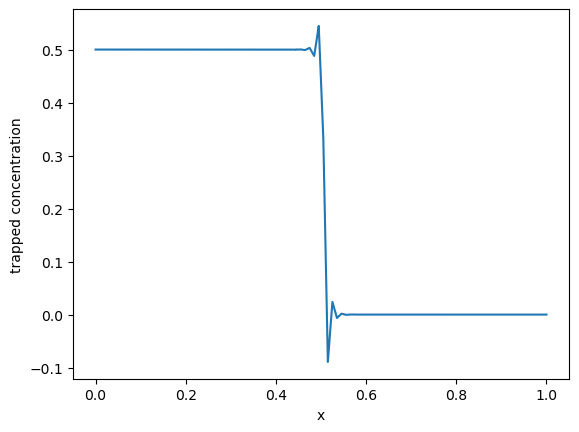

In [2]:
data = np.genfromtxt("task13/trapped_concentration_multi.txt", delimiter=",", skip_header=1)

import matplotlib.pyplot as plt

sorted_data = data[data[:, 0].argsort()]
plt.plot(sorted_data[:, 0], sorted_data[:, 1])

plt.xlabel("x")
plt.ylabel("trapped concentration")
plt.show()

These oscillations around the interface discontinuity overshoots and undershoots are due to the [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon).

This phenomenon occurs in finite element when trying to approximate a discontinuous function with continuous elements (see [ten Eikelder et al](https://doi.org/10.1142/S0218202524500040) for more info).

The best way to get rid of this behaviour is to use discontinuous elements.
Here, we'll change the ``traps_element_type`` in ``my_model.settings`` to ``"DG"`` (Discontinuous Galerkin). 

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


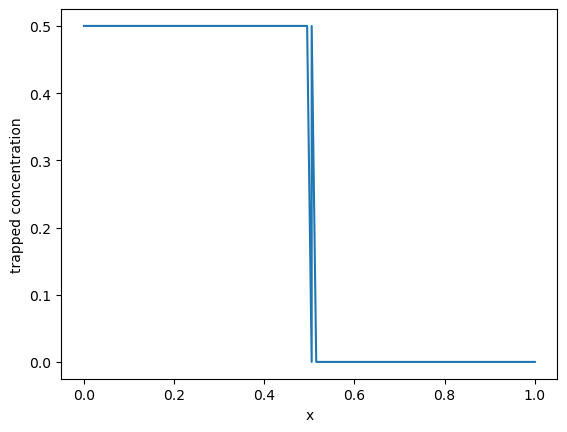

In [3]:
my_model.settings.traps_element_type = "DG"
my_model.initialise()
my_model.run()


data = np.genfromtxt("task13/trapped_concentration_multi.txt", delimiter=",", skip_header=1)

sorted_data = data[data[:, 0].argsort()]
plt.plot(sorted_data[:, 0], sorted_data[:, 1])

plt.xlabel("x")
plt.ylabel("trapped concentration")
plt.show()

Now we can see the oscillations have disappeared! 🎉

**Note:** The **new** weird behaviour at the interface is due to the fact that ``TXTExport`` projects the solution onto a new DG functionspace and this projection isn't perfect. This will not show up in Paraview with ``XDMFExport``

## Traps non homogeneously distributed

This phenomenon occurs for all discontinuities, even in single material cases.
To illustrate this, let's consider a case with one material on $\Omega = [0, 1]$ and a trap with a density of 1 for $x \in [0, 5]$ and 0 otherwise.

We do this using ``sympy.Piecewise``.

In [4]:
import festim as F
import numpy as np
import sympy as sp

my_model = F.Simulation()

vertices = np.concatenate([
    np.linspace(0, 0.5, 50),
    np.linspace(0.5, 1, 50),
])
my_model.mesh = F.MeshFromVertices(vertices)
my_model.materials = F.Material(id=1, D_0=1, E_D=0)

my_model.traps = F.Trap(
    k_0=1,
    E_k=0,
    p_0=1,
    E_p=0,
    density=sp.Piecewise((1, F.x < 0.5), (0, True)),
    materials=my_model.materials[0],
)

my_model.T = 300

my_model.boundary_conditions = [F.DirichletBC(surfaces=[1, 2], value=1, field="solute")]

my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    transient=False,
)

my_model.exports = [F.TXTExport(filename="task13/trapped_concentration.txt", field=1)]

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


Again we can plot the trapped concentration profile and observe similar oscilliations.

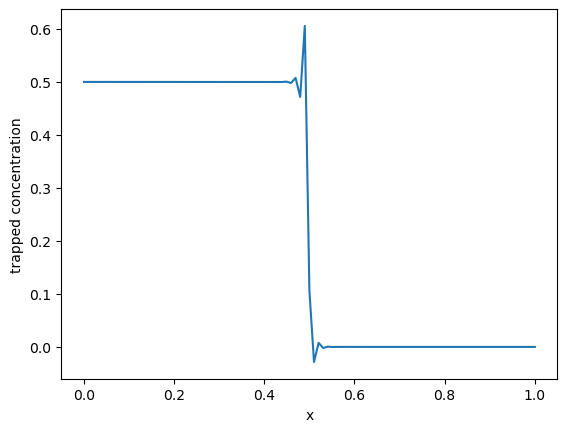

In [5]:
data = np.genfromtxt("task13/trapped_concentration.txt", delimiter=",", skip_header=1)

sorted_data = data[data[:, 0].argsort()]
plt.plot(sorted_data[:, 0], sorted_data[:, 1])

plt.xlabel("x")
plt.ylabel("trapped concentration")
plt.show()

By changing the trap element type to DG, we can greatly mitigate the Gibbs phenomenon. As before, the DG projection in ``TXTExport`` isn't perfect and one should use ``XDMFExport`` for a cleaner plot.

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


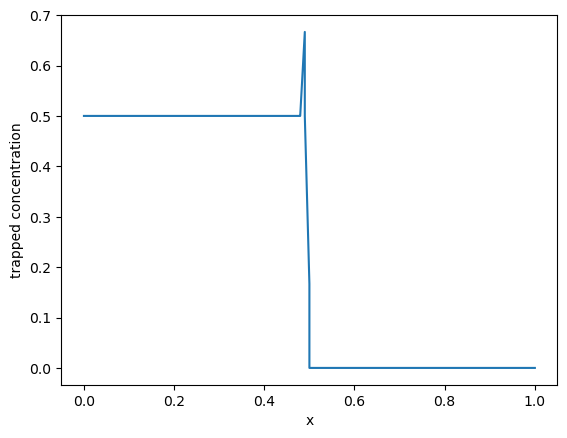

In [6]:
my_model.settings.traps_element_type = "DG"
my_model.initialise()
my_model.run()

data = np.genfromtxt("task13/trapped_concentration.txt", delimiter=",", skip_header=1)

sorted_data = data[data[:, 0].argsort()]

plt.plot(sorted_data[:, 0], sorted_data[:, 1])

plt.xlabel("x")
plt.ylabel("trapped concentration")
plt.show()

## Conclusion

Now you may wonder, why not use DG elements all the time then?

Well the thing with DG is that it duplicates degrees of freedom on the edges. Here's an example on three triangular cells with CG elements vs DG elements (order 4).

![Alt text](https://canada1.discourse-cdn.com/free1/uploads/festim/original/1X/2e63978aac2a2f81a3e73e9612b4ad7904b88aaa.png)

This means that problems using DG elements have overall more degrees of freedom than when using CG.
Therefore, since most problems are mono-material, we decided to set the defaults to CG.